Part 1: Data Merge and Exploratory Data Analysis

1. Loading customer datasets
2. Exploratory Data Analysis (EDA) with visualizations
3. Data cleaning and preprocessing
4. Merging datasets with validation

1: SETUP AND IMPORTS

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats

In [7]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

2: LOAD DATASETS

In [28]:
def install_required_packages():
    """Install required packages if missing"""
    try:
        import openpyxl
    except ImportError:
        print("Installing required package: openpyxl")
        os.system(f"{sys.executable} -m pip install openpyxl")
        print("Package installed successfully!")

# Install packages if needed
install_required_packages()

# Create dataset folder if it doesn't exist
if not os.path.exists('dataset'):
    os.makedirs('dataset')
    print("Created 'dataset' folder")

# Load the datasets
print("LOADING DATASETS")
try:
    transactions_df = pd.read_excel('dataset/customer_transactions.xlsx')
    social_profiles_df = pd.read_excel('dataset/customer_social_profiles.xlsx')
    
    print(f"Transactions dataset loaded: {transactions_df.shape}")
    print(f"Social profiles dataset loaded: {social_profiles_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure both files are in the 'dataset' folder")


LOADING DATASETS
Transactions dataset loaded: (150, 6)
Social profiles dataset loaded: (155, 5)


3: EXPLORATORY DATA ANALYSIS (EDA)

In [9]:
print("EXPLORATORY DATA ANALYSIS - TRANSACTIONS DATASET")
# 3.1: Basic Information 
print(" Dataset Overview ")
print(f"Shape: {transactions_df.shape}")
print(f"\nColumn Names and Types:")
print(transactions_df.dtypes)

print(" First 5 Rows ")
print(transactions_df.head())

#  3.2: Summary Statistics 
print("Summary Statistics for Numerical Variables")
print(transactions_df.describe())

# Identify variable types
print("Variable Type Classification")
numerical_cols = transactions_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = transactions_df.select_dtypes(include=['object']).columns.tolist()
date_cols = [col for col in transactions_df.columns if 'date' in col.lower()]

print(f"Numerical variables ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical variables ({len(categorical_cols)}): {categorical_cols}")
print(f"Date variables ({len(date_cols)}): {date_cols}")

# 3.3: Missing Values Analysis 
print(" Missing Values ")
missing_data = transactions_df.isnull().sum()
missing_percent = (missing_data / len(transactions_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0])

EXPLORATORY DATA ANALYSIS - TRANSACTIONS DATASET
 Dataset Overview 
Shape: (150, 6)

Column Names and Types:
customer_id_legacy             int64
transaction_id                 int64
purchase_amount                int64
purchase_date         datetime64[ns]
product_category              object
customer_rating              float64
dtype: object
 First 5 Rows 
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothin

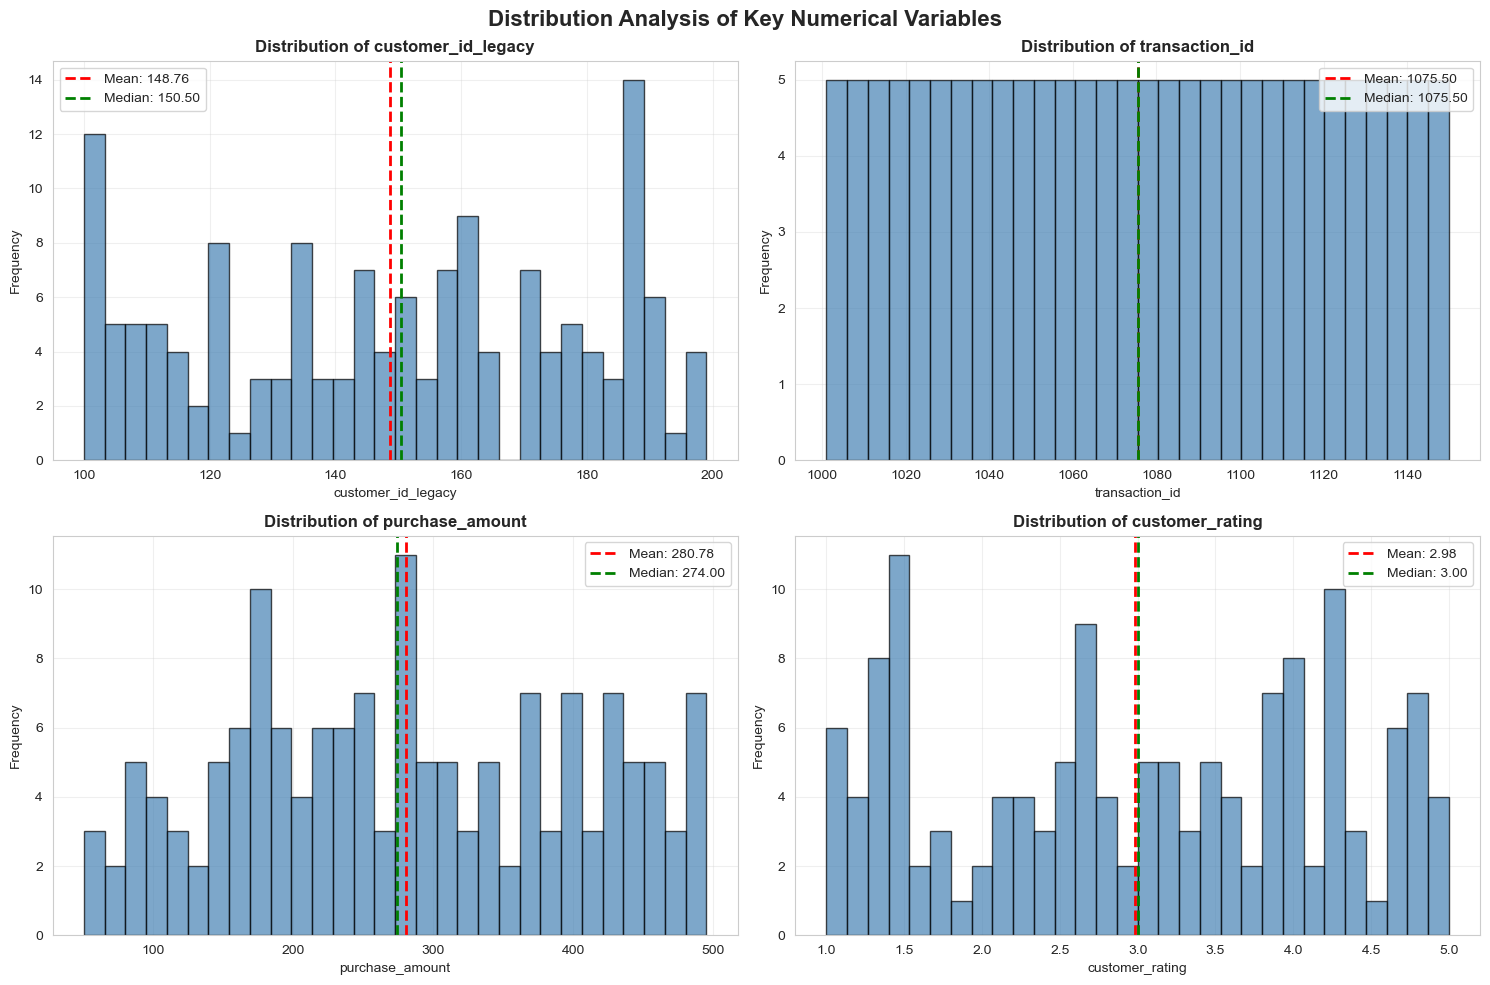

INTERPRETATION:
- The distributions show the spread and central tendency of key numerical features
- We can identify skewness and potential outliers from these histograms
- Mean vs Median comparison helps detect skewed distributions


In [27]:
# PLOT 1: DISTRIBUTION OF NUMERICAL VARIABLES
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Analysis of Key Numerical Variables', fontsize=16, fontweight='bold')

# Plot distributions for key numerical columns
num_cols_to_plot = numerical_cols[:4]  # Plot first 4 numerical columns

for idx, col in enumerate(num_cols_to_plot):
    row = idx // 2
    col_idx = idx % 2
    ax = axes[row, col_idx]
    
    # Histogram with KDE
    transactions_df[col].hist(bins=30, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(f'Distribution of {col}', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = transactions_df[col].mean()
    median_val = transactions_df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.savefig('plot1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- The distributions show the spread and central tendency of key numerical features")
print("- We can identify skewness and potential outliers from these histograms")
print("- Mean vs Median comparison helps detect skewed distributions")

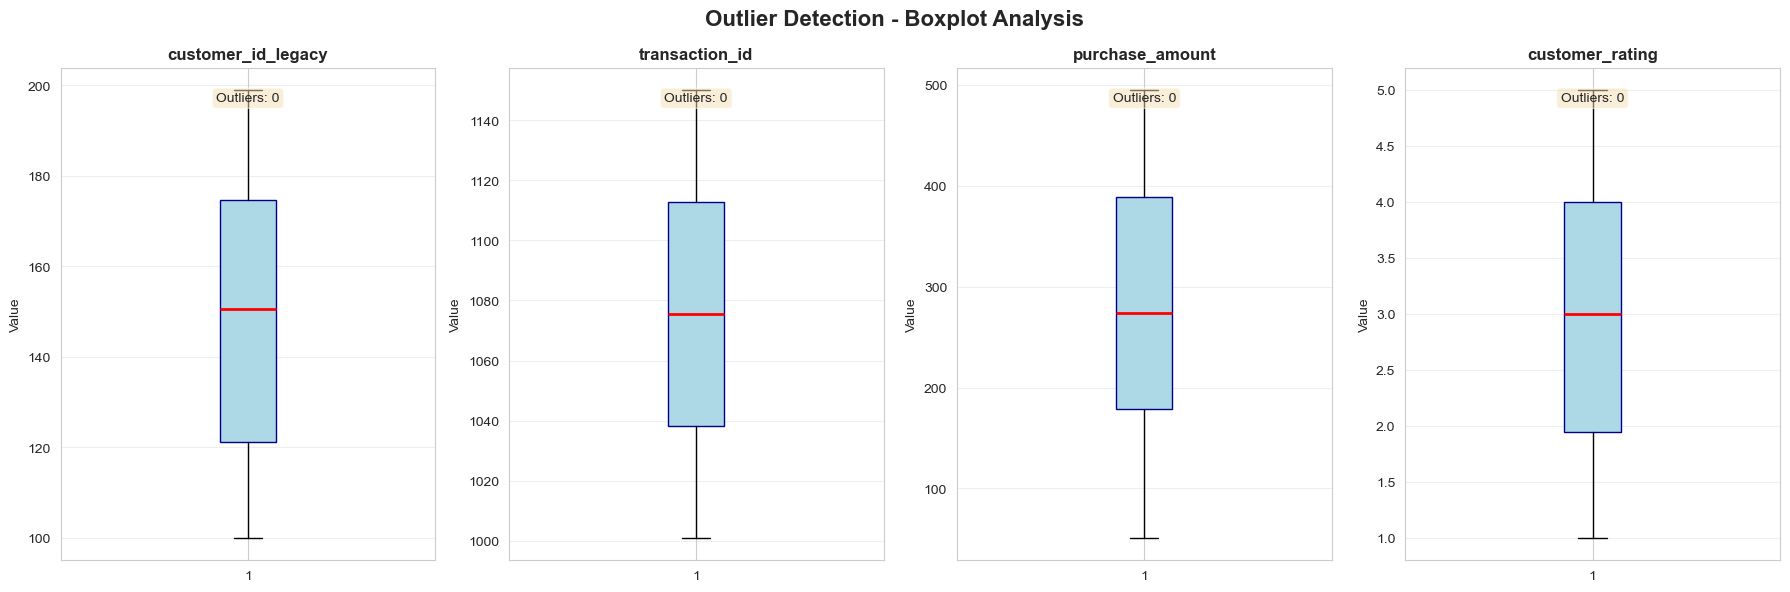

INTERPRETATION:
- Boxplots reveal outliers (points beyond whiskers)
- Outliers may represent data entry errors or legitimate extreme values
- These need to be handled appropriately during data cleaning


In [16]:
# PLOT 2: OUTLIER DETECTION USING BOXPLOTS
fig, axes = plt.subplots(1, len(num_cols_to_plot), figsize=(18, 6))
fig.suptitle('Outlier Detection - Boxplot Analysis', fontsize=16, fontweight='bold')

for idx, col in enumerate(num_cols_to_plot):
    ax = axes[idx]
    
    # Create boxplot
    box = ax.boxplot(transactions_df[col].dropna(), patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    box['boxes'][0].set_edgecolor('darkblue')
    box['medians'][0].set_color('red')
    box['medians'][0].set_linewidth(2)
    
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate outlier statistics
    Q1 = transactions_df[col].quantile(0.25)
    Q3 = transactions_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = transactions_df[(transactions_df[col] < Q1 - 1.5*IQR) | 
                              (transactions_df[col] > Q3 + 1.5*IQR)][col]
    
    # Add outlier count
    ax.text(0.5, 0.95, f'Outliers: {len(outliers)}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plot2_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- Boxplots reveal outliers (points beyond whiskers)")
print("- Outliers may represent data entry errors or legitimate extreme values")
print("- These need to be handled appropriately during data cleaning")

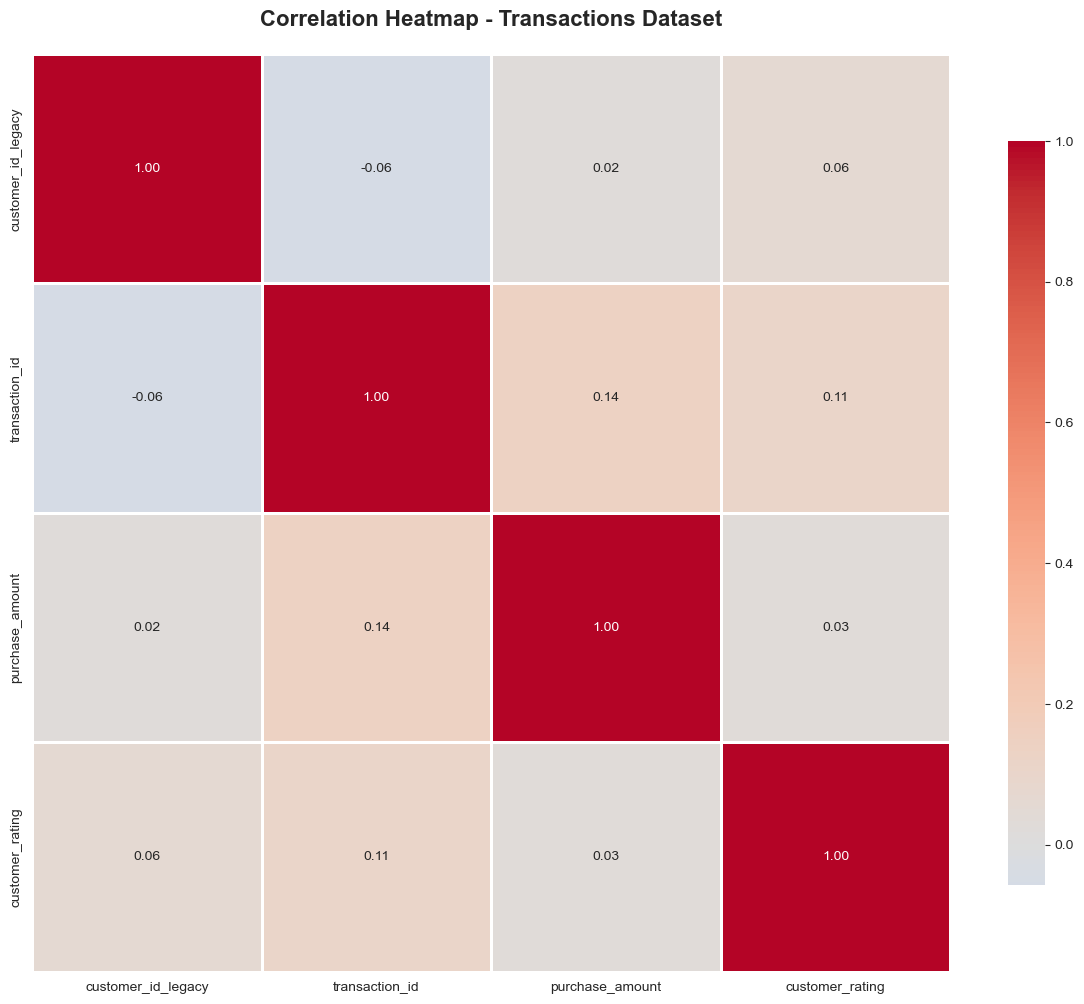

INTERPRETATION:
- Strong positive correlations (red) indicate variables that move together
- Strong negative correlations (blue) indicate inverse relationships
- Weak correlations (white) suggest independence between variables
- This helps identify redundant features and important relationships


In [17]:
# PLOT 3: CORRELATION HEATMAP
# Select numerical columns for correlation
correlation_data = transactions_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap - Transactions Dataset', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plot3_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- Strong positive correlations (red) indicate variables that move together")
print("- Strong negative correlations (blue) indicate inverse relationships")
print("- Weak correlations (white) suggest independence between variables")
print("- This helps identify redundant features and important relationships")

4: EDA FOR SOCIAL PROFILES DATASET

EXPLORATORY DATA ANALYSIS - SOCIAL PROFILES DATASET
 Dataset Overview 
Shape: (155, 5)

Column Names and Types:
customer_id_new             object
social_media_platform       object
engagement_score             int64
purchase_interest_score    float64
review_sentiment            object
dtype: object
 Summary Statistics 
       engagement_score  purchase_interest_score
count        155.000000               155.000000
mean          75.606452                 3.152903
std           14.568021                 1.142867
min           50.000000                 1.000000
25%           63.500000                 2.350000
50%           77.000000                 3.200000
75%           87.500000                 4.100000
max           99.000000                 5.000000


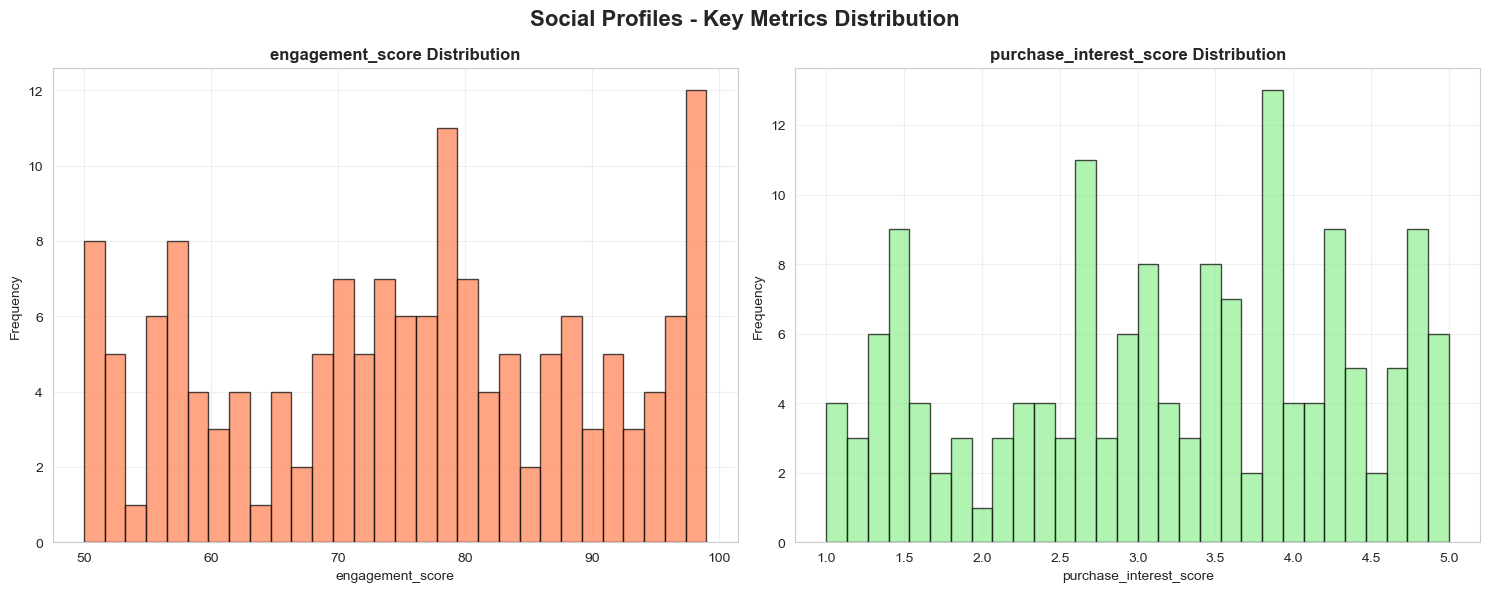

In [18]:
print("EXPLORATORY DATA ANALYSIS - SOCIAL PROFILES DATASET")
print(" Dataset Overview ")
print(f"Shape: {social_profiles_df.shape}")
print(f"\nColumn Names and Types:")
print(social_profiles_df.dtypes)

print(" Summary Statistics ")
print(social_profiles_df.describe())

# Additional visualization for social profiles
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Social Profiles - Key Metrics Distribution', fontsize=16, fontweight='bold')

# Plot engagement score if available
social_num_cols = social_profiles_df.select_dtypes(include=[np.number]).columns.tolist()
if len(social_num_cols) >= 2:
    axes[0].hist(social_profiles_df[social_num_cols[0]], bins=30, 
                 color='coral', alpha=0.7, edgecolor='black')
    axes[0].set_title(f'{social_num_cols[0]} Distribution', fontweight='bold')
    axes[0].set_xlabel(social_num_cols[0])
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(social_profiles_df[social_num_cols[1]], bins=30, 
                 color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1].set_title(f'{social_num_cols[1]} Distribution', fontweight='bold')
    axes[1].set_xlabel(social_num_cols[1])
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot4_social_profiles.png', dpi=300, bbox_inches='tight')
plt.show()


5: DATA CLEANING

In [21]:
print("DATA CLEANING & PREPROCESSING")
def handle_nulls_and_duplicates(df, df_name):
    """Handle null values and duplicates in dataframe"""
    print(f"Handling Nulls and Duplicates for {df_name}")
    
    # Check for null values
    print("Null values before handling:")
    print(df.isnull().sum())
    
    # Handle null values based on column type
    for column in df.columns:
        if df[column].isnull().any():
            null_count = df[column].isnull().sum()
            if df[column].dtype in ['float64', 'int64']:
                # For numerical columns, fill with median
                median_val = df[column].median()
                df[column] = df[column].fillna(median_val)
                print(f"Filled {null_count} nulls in {column} with median: {median_val}")
            elif df[column].dtype == 'object':
                # For categorical columns, fill with mode
                mode_val = df[column].mode()[0] if not df[column].mode().empty else 'Unknown'
                df[column].fillna(mode_val, inplace=True)
                print(f"Filled {null_count} nulls in {column} with mode: {mode_val}")
    
    # Check for duplicates
    initial_rows = len(df)
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")
    
    if duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f"Removed {duplicates} duplicate rows")
    
    print(f"Rows after cleaning: {len(df)} (removed {initial_rows - len(df)})")
    return df

def fix_data_types(df, df_name):
    """Fix data types for optimal processing"""
    print(f"Fixing Data Types for {df_name}")
    
    print("Data types before fixing:")
    print(df.dtypes)
    
    # Convert date columns
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='mixed', errors='coerce')
            print(f"Converted {col} to datetime")
    
    # Convert ID columns to appropriate types
    id_columns = [col for col in df.columns if 'id' in col.lower()]
    for col in id_columns:
        if col in df.columns and df[col].dtype in ['float64', 'object']:
            try:
                df[col] = df[col].astype('Int64')
                print(f"Converted {col} to integer")
            except (ValueError, TypeError):
                df[col] = df[col].astype(str)
                print(f"Converted {col} to string")
    
    # Convert categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 50]
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category ({df[col].nunique()} unique values)")
    
    print("Data types after fixing:")
    print(df.dtypes)
    
    return df

# Apply cleaning
transactions_clean = handle_nulls_and_duplicates(transactions_df.copy(), "Transactions")
social_clean = handle_nulls_and_duplicates(social_profiles_df.copy(), "Social Profiles")

# Fix data types
transactions_clean = fix_data_types(transactions_clean, "Transactions")
social_clean = fix_data_types(social_clean, "Social Profiles")

DATA CLEANING & PREPROCESSING
Handling Nulls and Duplicates for Transactions
Null values before handling:
customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64
Filled 10 nulls in customer_rating with median: 3.0
Duplicate rows found: 0
Rows after cleaning: 150 (removed 0)
Handling Nulls and Duplicates for Social Profiles
Null values before handling:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64
Duplicate rows found: 5
Removed 5 duplicate rows
Rows after cleaning: 150 (removed 5)
Fixing Data Types for Transactions
Data types before fixing:
customer_id_legacy             int64
transaction_id                 int64
purchase_amount                int64
purchase_date         datetime64[ns]
product_category              object
customer_rating              float64
dtype: objec

6: MERGE LOGIC JUSTIFICATION

In [22]:
print("MERGE LOGIC & JUSTIFICATION")
def justify_join_logic(transactions_df, social_profiles_df):
    """Analyze and justify the join logic"""
    print(" Join Logic Justification")
    
    # Analyze customer ID mapping
    transactions_customers = set(transactions_df['customer_id_legacy'].astype(int).astype(str))
    social_customers = set(social_profiles_df['customer_id_new'].str.replace('A', '').astype(int).astype(str))
    
    common_customers = transactions_customers.intersection(social_customers)
    only_transactions = transactions_customers - social_customers
    only_social = social_customers - transactions_customers
    
    print(f"Total unique customers in transactions: {len(transactions_customers)}")
    print(f"Total unique customers in social profiles: {len(social_customers)}")
    print(f"Common customers (can be merged): {len(common_customers)}")
    print(f"Customers only in transactions: {len(only_transactions)}")
    print(f"Customers only in social profiles: {len(only_social)}")
    
    # Calculate overlap percentages
    trans_overlap = len(common_customers) / len(transactions_customers) * 100
    social_overlap = len(common_customers) / len(social_customers) * 100
    
    print(f"Overlap analysis:")
    print(f"{trans_overlap:.1f}% of transaction customers have social profiles")
    print(f"{social_overlap:.1f}% of social profile customers have transactions")
    
    # Justify inner join choice
    print(f"JOIN TYPE SELECTED: INNER JOIN")
    print("Justification:")
    print("  1. We want only customers who exist in BOTH datasets")
    print("  2. This ensures complete customer profiles (both transaction and social data)")
    print("  3. Avoids null values for key customer attributes")
    print("  4. Maintains data integrity for predictive modeling")
    print("  5. Ensures all features are available for each customer")
    
    return len(common_customers) > 0

# Justify merge
if not justify_join_logic(transactions_clean, social_clean):
    print("WARNING: No common customers found! Check ID mapping.")

# Prepare for merge
transactions_clean['customer_id_common'] = transactions_clean['customer_id_legacy'].astype(int).astype(str)
social_clean['customer_id_common'] = social_clean['customer_id_new'].str.replace('A', '').astype(int).astype(str)

MERGE LOGIC & JUSTIFICATION
 Join Logic Justification
Total unique customers in transactions: 75
Total unique customers in social profiles: 84
Common customers (can be merged): 61
Customers only in transactions: 14
Customers only in social profiles: 23
Overlap analysis:
81.3% of transaction customers have social profiles
72.6% of social profile customers have transactions
JOIN TYPE SELECTED: INNER JOIN
Justification:
  1. We want only customers who exist in BOTH datasets
  2. This ensures complete customer profiles (both transaction and social data)
  3. Avoids null values for key customer attributes
  4. Maintains data integrity for predictive modeling
  5. Ensures all features are available for each customer


7: PERFORM MERGE

In [23]:
print("PERFORMING DATA MERGE")
# Perform inner join
merged_df = pd.merge(
    transactions_clean,
    social_clean,
    on='customer_id_common',
    how='inner',
    validate='many_to_many'
)
print(f"Merged dataset shape: {merged_df.shape}")

PERFORMING DATA MERGE
Merged dataset shape: (213, 12)


8: POST-MERGE VALIDATION

In [24]:
print("POST-MERGE QUALITY CHECKS")
def perform_post_merge_checks(merged_df, original_transactions, original_social):
    """Perform comprehensive checks after merge"""
    
    # Basic shape and size checks
    print(f" Shape Validation")
    print(f"Merged dataset shape: {merged_df.shape}")
    print(f"Expected columns: {len(original_transactions.columns) + len(original_social.columns) - 1}")
    
    # Check for null values in merged data
    print(" Null Value Check")
    null_summary = merged_df.isnull().sum()
    total_nulls = null_summary.sum()
    if total_nulls == 0:
        print("No null values in merged dataset")
    else:
        print(f"Null values found in {(null_summary > 0).sum()} columns:")
        for col, null_count in null_summary.items():
            if null_count > 0:
                print(f"  {col}: {null_count} nulls ({null_count/len(merged_df)*100:.1f}%)")
    
    # Check for duplicates
    print(" Duplicate Check ")
    merged_duplicates = merged_df.duplicated().sum()
    if merged_duplicates == 0:
        print(" No duplicate rows in merged dataset")
    else:
        print(f" Found {merged_duplicates} duplicate rows")
    
    # Verify customer count
    print(" Customer Count Validation")
    unique_customers = merged_df['customer_id_common'].nunique()
    print(f"Unique customers in merged data: {unique_customers}")
    
    # Data integrity checks
    print(" Data Integrity Checks")
    checks_passed = 0
    total_checks = 0
    
    # Check 1: Customer IDs are strings
    total_checks += 1
    if merged_df['customer_id_common'].dtype == 'object':
        print(" Customer IDs are properly formatted as strings")
        checks_passed += 1
    else:
        print(" Customer IDs are not strings")
    
    # Check 2: No negative values in amount columns
    amount_cols = [col for col in merged_df.columns if 'amount' in col.lower() or 'price' in col.lower()]
    for col in amount_cols:
        if col in merged_df.columns:
            total_checks += 1
            if (merged_df[col] >= 0).all():
                print(f"No negative values in {col}")
                checks_passed += 1
            else:
                print(f"Found negative values in {col}")
    
    print(f"Integrity Score: {checks_passed}/{total_checks} checks passed")

perform_post_merge_checks(merged_df, transactions_clean, social_clean)

POST-MERGE QUALITY CHECKS
 Shape Validation
Merged dataset shape: (213, 12)
Expected columns: 12
 Null Value Check
Null values found in 1 columns:
  review_sentiment: 213 nulls (100.0%)
 Duplicate Check 
 No duplicate rows in merged dataset
 Customer Count Validation
Unique customers in merged data: 61
 Data Integrity Checks
 Customer IDs are properly formatted as strings
No negative values in purchase_amount
Integrity Score: 2/2 checks passed


9: SAVE MERGED DATASET

In [26]:
print("SAVING MERGED DATASET")
merged_file_path = 'dataset/merged_customer_data.xlsx'
merged_df.to_excel(merged_file_path, index=False)

print(f" Merged dataset saved to: {merged_file_path}")

# Final summary
print(f"FINAL SUMMARY")
print(f"Original transactions: {len(transactions_df)} records")
print(f"After cleaning: {len(transactions_clean)} records")
print(f"Original social profiles: {len(social_profiles_df)} records")
print(f"After cleaning: {len(social_clean)} records")
print(f"Final merged dataset: {len(merged_df)} records")
print(f"Merge efficiency: {len(merged_df)/len(transactions_clean)*100:.1f}% of cleaned transactions matched")

print("Sample of Merged Data (First 5 Rows)")
print(merged_df.head())


SAVING MERGED DATASET
 Merged dataset saved to: dataset/merged_customer_data.xlsx
FINAL SUMMARY
Original transactions: 150 records
After cleaning: 150 records
Original social profiles: 155 records
After cleaning: 150 records
Final merged dataset: 213 records
Merge efficiency: 142.0% of cleaned transactions matched
Sample of Merged Data (First 5 Rows)
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 151            1001              408    2024-01-01   
2                 151            1001              408    2024-01-01   
3                 192            1002              332    2024-01-02   
4                 114            1003              442    2024-01-03   

  product_category  customer_rating customer_id_common customer_id_new  \
0           Sports              2.3                151            A151   
1           Sports              2.3                151            

# Sound Data Collection and Processing 

 ## Audio Processing Pipeline
## This notebook implements a comprehensive audio processing pipeline for voice command analysis, including:
 - Audio visualization (waveforms and spectrograms)
 - Data augmentation (pitch shift, time stretch, noise injection)
 - Feature extraction (MFCCs, spectral features, temporal features)

In [8]:
# Import Required Libraries

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import os
import glob
from pathlib import Path


In [40]:
class AudioPipeline:
    def __init__(self, sample_rate=16000):
        """Initialize the audio processing pipeline with a given sample rate."""
        self.sample_rate = sample_rate
        self.output_dir = r"C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing"
        os.makedirs(self.output_dir, exist_ok=True)

        # Creating a new folder  for visualizations
        self.viz_dir = os.path.join(self.output_dir, 'audio_visualizations')
        os.makedirs(self.viz_dir, exist_ok=True)

        print(f"Audio Pipeline initialized with {sample_rate} Hz sample rate")
        print(f"  Output directory set to: {self.output_dir}")
        print(f"  Visualizations will be saved in: {self.viz_dir}")

    def load_and_visualize_audio(self, audio_path, save_viz=True):
        """Load audio and generate waveform + spectrogram visualizations."""
        if not os.path.exists(audio_path):
            print(f"⚠ Audio path not found: {audio_path}")
            return

        # Process all supported audio files inside a folder
        if os.path.isdir(audio_path):
            print(f"📁 Detected folder: {audio_path}")
            extensions = ('*.wav', '*.mp3', '*.flac', '*.ogg', '*.m4a')
            audio_files = []
            for ext in extensions:
                audio_files.extend(glob.glob(os.path.join(audio_path, ext)))

            if not audio_files:
                print("No audio files found in the folder.")
                return

            print(f"🎧 Found {len(audio_files)} audio file(s). Processing...\n")
            for i, file_path in enumerate(audio_files, start=1):
                print(f"  [{i}/{len(audio_files)}]")
                self._process_single_audio(file_path, save_viz)
            print("\n All audio files processed successfully.")
        else:
            
            self._process_single_audio(audio_path, save_viz)

    def _process_single_audio(self, file_path, save_viz=True):
        """Process one audio file."""
        filename = os.path.splitext(os.path.basename(file_path))[0]
        print(f"▶ Processing: {filename}")

        try:
            audio, sr = librosa.load(file_path, sr=self.sample_rate)
        except Exception as e:
            print(f" Failed to load {filename}: {e}")
            return

        if save_viz:
            # WAVEFORM 
            plt.figure(figsize=(12, 4))
            librosa.display.waveshow(audio, sr=sr, alpha=0.8)
            plt.title(f'Waveform: {filename}', fontsize=14, fontweight='bold')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Amplitude')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            waveform_path = os.path.join(self.viz_dir, f'{filename}_waveform.png')
            plt.savefig(waveform_path, dpi=300)
            plt.close()

            # SPECTROGRAM
            plt.figure(figsize=(12, 6))
            D = librosa.stft(audio)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
            plt.colorbar(img, format='%+2.0f dB')
            plt.title(f'Spectrogram: {filename}', fontsize=14, fontweight='bold')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Frequency (Hz)')
            plt.tight_layout()
            spectrogram_path = os.path.join(self.viz_dir, f'{filename}_spectrogram.png')
            plt.savefig(spectrogram_path, dpi=300)
            plt.close()

            print(f"    Visualizations saved for {filename} in {self.viz_dir}")
        return

if __name__ == "__main__":
    pipeline = AudioPipeline()
    audio_folder = r"C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing/audios"
    pipeline.load_and_visualize_audio(audio_folder)

Audio Pipeline initialized with 16000 Hz sample rate
  Output directory set to: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing
  Visualizations will be saved in: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audio_visualizations
📁 Detected folder: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing/audios
🎧 Found 4 audio file(s). Processing...

  [1/4]
▶ Processing: carine_confirm_transactions
    Visualizations saved for carine_confirm_transactions in C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audio_visualizations
  [2/4]
▶ Processing: carine_yes, approve
    Visualizations saved for carine_yes, approve in C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audio_visualizations
  [3/4]
▶ Processing: Eva_confirm_transactions
    Visualizations saved for Eva_confirm_transactions in C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audio_visualizations
  [4/4]
▶ Pro

## AudioPipeline Class Definition
 This class handles comprehensive audio processing operations. It initializes with a configurable sample rate (default 16kHz) and automatically creates output directories for storing visualizations. The pipeline supports loading individual audio files or processing entire folders containing multiple formats including WAV, MP3, FLAC, OGG, and M4A. For each audio file, it generates high quality waveform and spectrogram visualizations saved as 300 DPI PNG images. The class includes robust error handling for missing files and failed audio loads, with detailed progress reporting during batch processing operations.

In [28]:
class AudioPipeline:
    def __init__(self, sample_rate=16000, base_dir=r"C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing"):
        self.sample_rate = sample_rate
        self.base_dir = base_dir
        self.augmented_dir = os.path.join(self.base_dir, "augmented_audios")
        os.makedirs(self.augmented_dir, exist_ok=True)
        print(f"AudioPipeline initialized.\nAugmented files will be in '{self.augmented_dir}' and CSV in '{self.base_dir}'\n")

    def pitch_shift(self, audio, n_steps):
        return librosa.effects.pitch_shift(audio, sr=self.sample_rate, n_steps=n_steps)

    def time_stretch(self, audio, rate):
        return librosa.effects.time_stretch(audio, rate=rate)

    def add_background_noise(self, audio, noise_level=0.01):
        noise = np.random.randn(len(audio))
        freq = np.fft.rfftfreq(len(noise))
        freq[0] = 1
        pink_noise = np.fft.irfft(np.fft.rfft(noise) / np.sqrt(freq))
        if len(pink_noise) < len(audio):
            pink_noise = np.pad(pink_noise, (0, len(audio) - len(pink_noise)), mode='wrap')
        else:
            pink_noise = pink_noise[:len(audio)]
        pink_noise = pink_noise / np.max(np.abs(pink_noise))
        return np.clip(audio + noise_level * pink_noise, -1.0, 1.0)

    def augment_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)
        filename = os.path.splitext(os.path.basename(audio_path))[0]
        augmentations = {}

        # Pitch shift
        ps_audio = self.pitch_shift(audio, 2)
        ps_path = os.path.join(self.augmented_dir, f"{filename}_pitch_shift.wav")
        sf.write(ps_path, ps_audio, self.sample_rate)
        augmentations['pitch_shift'] = ps_path

        # Time stretch
        ts_audio = self.time_stretch(audio, 1.1)
        ts_path = os.path.join(self.augmented_dir, f"{filename}_time_stretch.wav")
        sf.write(ts_path, ts_audio, self.sample_rate)
        augmentations['time_stretch'] = ts_path

        # Background noise
        noise_audio = self.add_background_noise(audio, 0.01)
        noise_path = os.path.join(self.augmented_dir, f"{filename}_noise.wav")
        sf.write(noise_path, noise_audio, self.sample_rate)
        augmentations['noise'] = noise_path

        print(f"Augmented files for '{filename}':")
        for k, v in augmentations.items():
            print(f"  {k}: {v}")
        print()
        return augmentations

    def extract_audio_features(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.sample_rate)
        features = {
            'file_name': os.path.basename(audio_path),
            'file_path': audio_path,
            'duration': len(audio)/sr
        }

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        for i in range(20):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])

        features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
        features['spectral_centroid_std'] = np.std(librosa.feature.spectral_centroid(y=audio, sr=sr))
        features['spectral_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
        features['spectral_rolloff_std'] = np.std(librosa.feature.spectral_rolloff(y=audio, sr=sr))
        features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
        features['spectral_bandwidth_std'] = np.std(librosa.feature.spectral_bandwidth(y=audio, sr=sr))

        zcr = librosa.feature.zero_crossing_rate(audio)[0]
        features['zero_crossing_rate_mean'] = np.mean(zcr)
        features['zero_crossing_rate_std'] = np.std(zcr)

        rms = librosa.feature.rms(y=audio)[0]
        features['rms_energy_mean'] = np.mean(rms)
        features['rms_energy_std'] = np.std(rms)
        features['rms_energy_max'] = np.max(rms)
        features['rms_energy_min'] = np.min(rms)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        for i in range(12):
            features[f'chroma_{i+1}_mean'] = np.mean(chroma[i])

        tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
        features['tempo'] = tempo

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        features['mel_spectrogram_mean'] = np.mean(mel_spec)
        features['mel_spectrogram_std'] = np.std(mel_spec)

        return features

    def process_folder(self, folder_path):
        """Augment all audio files, extract features, save CSV, and display summary."""
        if not os.path.exists(folder_path):
            print(f"ERROR: The folder '{folder_path}' does not exist!")
            return None

        feature_list = []
        audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3'))]
        print(f"Found {len(audio_files)} audio files in '{folder_path}'\n")

        for f in audio_files:
            full_path = os.path.join(folder_path, f)
            self.augment_audio(full_path)
            feats = self.extract_audio_features(full_path)
            feature_list.append(feats)

        df = pd.DataFrame(feature_list)
        csv_path = os.path.join(self.base_dir, "audio_features.csv")
        df.to_csv(csv_path, index=False)
        print(f"Features saved to: {csv_path}\n")
        print("First 5 rows of features:\n")
        display(df.head())
        return df


pipeline = AudioPipeline(sample_rate=16000)
df = pipeline.process_folder(r"C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audios") 

if df is not None:
    print("\nDataset shape:", df.shape)
    print("\nColumns:", df.columns.tolist())



AudioPipeline initialized.
Augmented files will be in 'C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\augmented_audios' and CSV in 'C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing'

Found 4 audio files in 'C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\audios'

Augmented files for 'carine_confirm_transactions':
  pitch_shift: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\augmented_audios\carine_confirm_transactions_pitch_shift.wav
  time_stretch: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\augmented_audios\carine_confirm_transactions_time_stretch.wav
  noise: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\augmented_audios\carine_confirm_transactions_noise.wav

Augmented files for 'carine_yes, approve':
  pitch_shift: C:\Users\PC\Documents\Formative2-Data-Preprocessing\Audio processing\augmented_audios\carine_yes, approve_pitch_shift.wav
  time_stretch: 

,file_name,file_path,duration,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,...,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,tempo,mel_spectrogram_mean,mel_spectrogram_std
0,carine_confirm_transactions.wav,C:\Users\PC\Documents\Formative2-Data-Preproce...,2.322000,-580.033691,178.120438,18.338223,56.816471,34.966053,37.074478,-39.276161,...,0.300256,0.186697,0.204671,0.377751,0.582203,0.504227,0.294510,[81.52173913043478],0.013563,0.134683
1,"carine_yes, approve.wav",C:\Users\PC\Documents\Formative2-Data-Preproce...,1.950500,-604.000549,162.835175,25.515104,56.448635,26.031040,26.927000,-39.163185,...,0.226066,0.266759,0.446314,0.579943,0.628102,0.425327,0.227370,[117.1875],0.021377,0.236541
2,Eva_confirm_transactions.wav,C:\Users\PC\Documents\Formative2-Data-Preproce...,2.261375,-501.617676,137.466309,117.867821,67.819092,34.076656,30.526127,11.664201,...,0.576466,0.528101,0.460976,0.442938,0.455085,0.388428,0.431927,[133.92857142857142],0.085305,0.984739
3,"Eva_yes, approve.wav",C:\Users\PC\Documents\Formative2-Data-Preproce...,1.493375,-489.343719,123.489235,105.134972,65.393051,32.486942,32.379654,5.487062,...,0.291141,0.402338,0.519642,0.507580,0.412668,0.339395,0.346491,[117.1875],0.123575,1.540928



Dataset shape: (4, 70)

Columns: ['file_name', 'file_path', 'duration', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'mfcc_13_mean', 'mfcc_13_std', 'mfcc_14_mean', 'mfcc_14_std', 'mfcc_15_mean', 'mfcc_15_std', 'mfcc_16_mean', 'mfcc_16_std', 'mfcc_17_mean', 'mfcc_17_std', 'mfcc_18_mean', 'mfcc_18_std', 'mfcc_19_mean', 'mfcc_19_std', 'mfcc_20_mean', 'mfcc_20_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_rolloff_mean', 'spectral_rolloff_std', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std', 'rms_energy_mean', 'rms_energy_std', 'rms_energy_max', 'rms_energy_min', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_me

## AudioPipeline Overview
This class handles audio processing including augmentation (pitch shift, time stretch, pink noise) and feature extraction (MFCCs, spectral features, ZCR, RMS, chroma, tempo, mel-spectrogram). It processes all audio files in a folder, saves augmented files, and exports a CSV with extracted features.
## Initialize and Process
Create an `AudioPipeline` instance (16kHz) to automatically augment audio files, extract features, and compile results into a structured dataset.
## Dataset Summary
Displays the dataset shape and lists all feature columns, giving an overview of processed audio data and total samples.
